In [1]:
%load_ext autoreload
%autoreload 2

from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import sys
import os

sys.path.append(os.path.join(os.path.abspath('.'),'../../plankton'))

In [2]:
import plankton as pl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
data_folder='data/'

umpp=0.152

coordinates = pd.read_csv(os.path.join(data_folder,'./coordinates_joined.csv'))
mask = ~coordinates.gene.isin(['CGA','KISS1'])
mask[np.random.uniform(size=mask.size)<0.3]=True

dapi_image = plt.imread(os.path.join(data_folder,'156KS_FITC_backround.tif')).sum(-1)
dapi_image -=dapi_image.min()
dapi_image = 1-(dapi_image/dapi_image.max())**0.7

# bg_cells= np.load('./data/leftCA1/label_image.coo.npz')
# cell_mask = np.zeros(bg_cells['shape'])
# cell_mask[bg_cells['row'],bg_cells['col']]=bg_cells['data']

In [4]:
sdata = pl.SpatialData(genes=coordinates.gene,
                       x_coordinates=coordinates.X*umpp,
                       y_coordinates=coordinates.Y*umpp-35,
                      pixel_maps=[pl.PixelMap(dapi_image,upscale=0.25/umpp),])[mask]

(<matplotlib.collections.PathCollection at 0x7f1cf8bb42b0>, None, None)

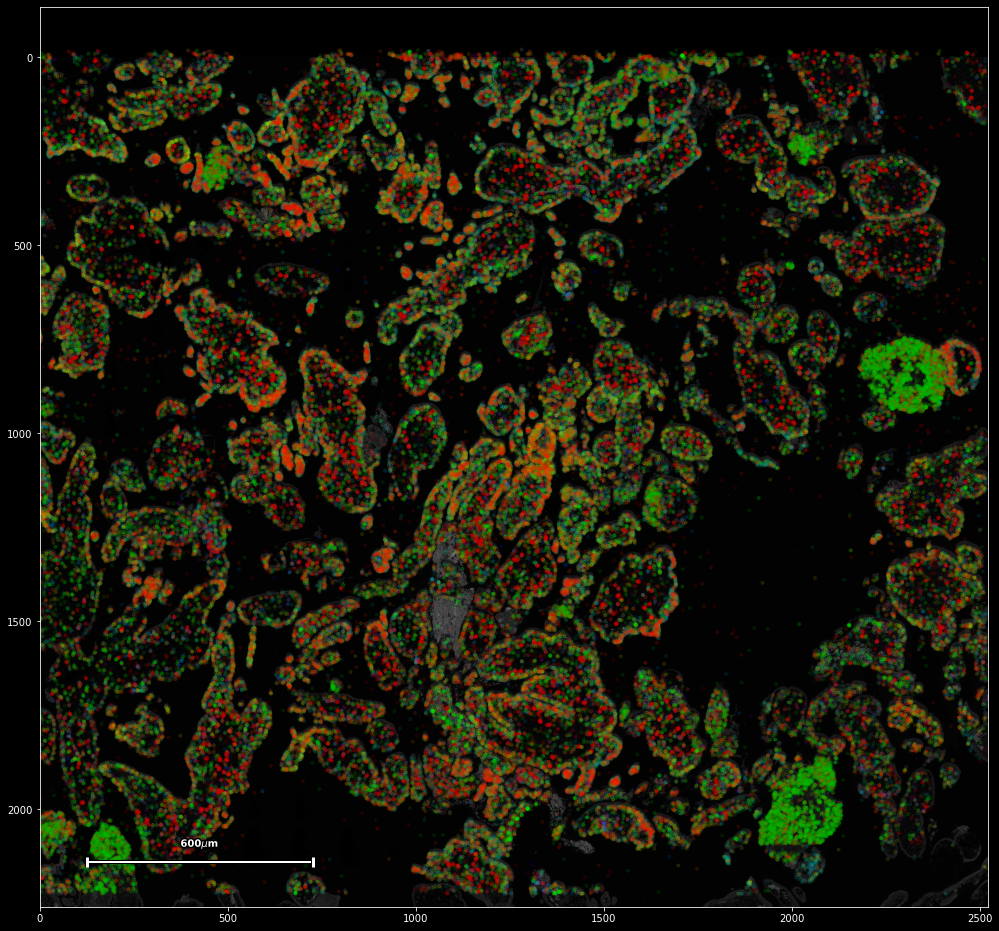

In [5]:
plt.figure(figsize=(17,17))
sdata.scatter(alpha=0.1,marker='.')

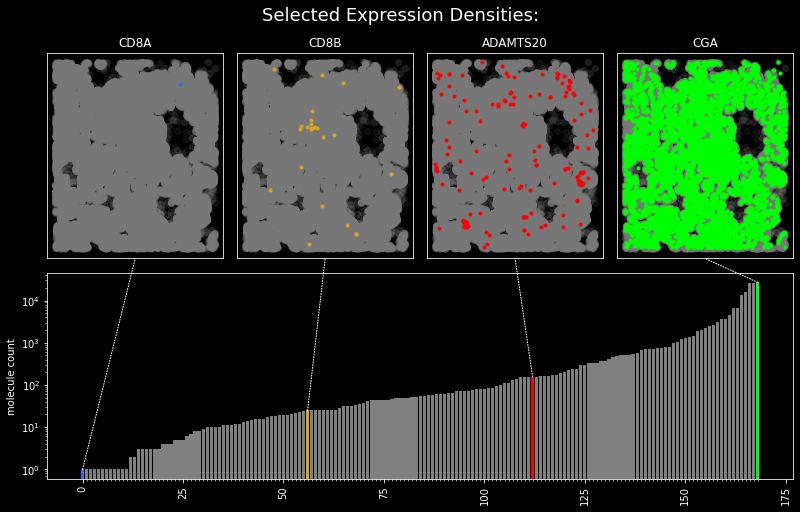

In [6]:
sdata.plot_overview()

In [7]:
knn_neighbors=160
bandwidth=5
n_neighbors=30
metric='euclidean'
min_dist=0.03
random_state=42
zero_weight=2

_=sdata.graph.update_knn(n_neighbors=knn_neighbors)

sdata.graph.run_umap(bandwidth=bandwidth,n_neighbors=n_neighbors, min_dist=min_dist, metric=metric, random_state=random_state,zero_weight=zero_weight)



<IPython.core.display.Javascript object>


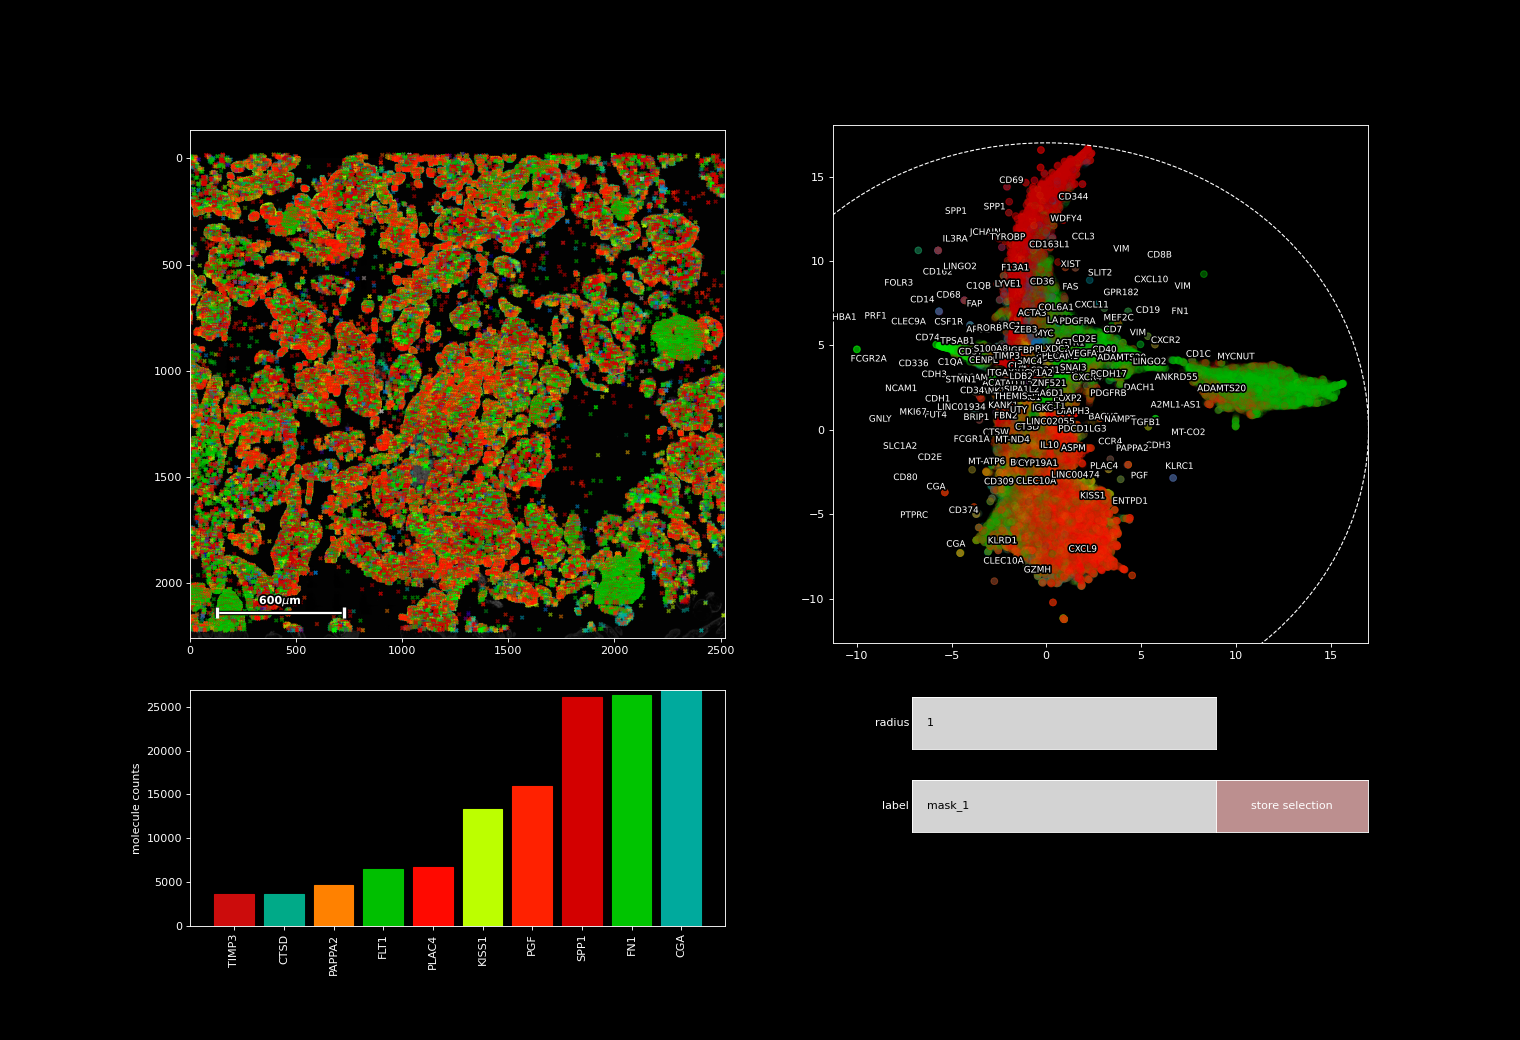

In [8]:
%matplotlib notebook

plt.style.use('dark_background')

plt.figure(figsize=(19,13))
sdata.graph.umap_interactive(color_prop='genes',umap_kwargs={'alpha':0.05,'thlds_text':[0.8,0.03,200],'text_distance':1.5,'legend':False,'text_kwargs':{'fontsize':8},'text_prop':'genes'})

<IPython.core.display.Javascript object>


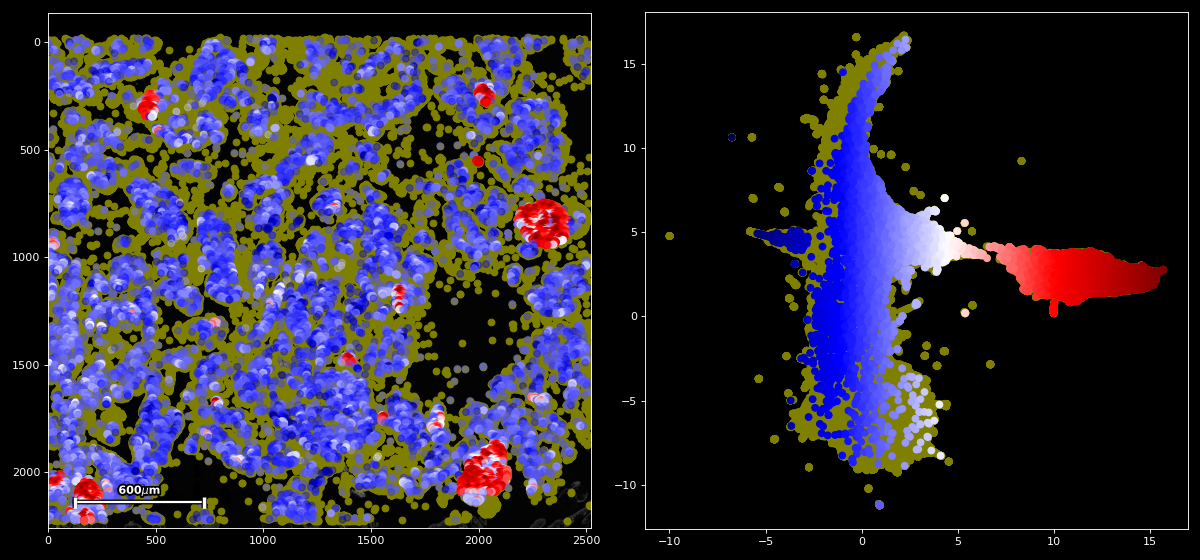

In [26]:
plt.figure(figsize=(15,7))
clr = 'olive'
plt.subplot(121)
sdata.scatter(color=clr)
sdata[sdata.g=='FN1'].scatter(c=sdata[sdata.g=='FN1'].graph.umap[:,0],alpha=0.4,cmap='seismic')

plt.subplot(122)
sdata.graph.plot_umap(color=clr)
sdata[sdata.g=='FN1'].graph.plot_umap(c=sdata[sdata.g=='FN1'].graph.umap[:,0],cmap='seismic',)

plt.tight_layout()

In [11]:
sdata['act']=(sdata.act_1|sdata.act_2|sdata.act_3|sdata.act_4)

In [4]:
# sdata.save('qian_segmemnts.pl')

Index(['g', 'x', 'y', 'gene_id', 'act_1', 'act_2', 'act_3', 'act_4', 'act',
       'inh_1', 'inh_2'],
      dtype='object')
